<a href="https://colab.research.google.com/github/toby-j/COM3025-CW/blob/main/gradients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports



In [3]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras import Sequential
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import tensorflow

# Global functions

In [4]:
def output_metrics(model, test_data, test_labels):
  predictions = model.predict(test_data)

  y_pred  = np.argmax(predictions, axis=-1)
  y_test = np.argmax(test_labels, axis=-1)

  print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
  print(f'F1 score: {f1_score(y_test, y_pred, average="weighted")}')
  print(f'Precision score: {precision_score(y_test, y_pred, average="weighted")}')
  print(f'Recall score: {recall_score(y_test, y_pred, average="weighted")}')

In [5]:
def read_and_resize_image(image_path, size):
    img = cv2.imread(image_path)
    img = cv2.resize(img, size)
    return img

# Kaggle dataset loading
 https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000

In [6]:
!pip install -q kaggle
from google.colab import files 

Upload your kaggle .json api key

In [7]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"plastictrees","key":"e4da464bc9f316b32dbb185235a328e7"}'}

In [8]:
!mkdir ~/.kaggle

In [9]:
!cp kaggle.json ~/.kaggle/

In [10]:
!chmod 600 ~/.kaggle/kaggle.json

In [11]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.19G/5.20G [00:50<00:00, 192MB/s]
100% 5.20G/5.20G [00:50<00:00, 110MB/s]


In [12]:
!unzip skin-cancer-mnist-ham10000.zip -d content

Streaming output truncated to the last 5000 lines.
  inflating: content/ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: content/ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: content/ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: content/ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: content/ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: content/ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: content/ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: content/ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: content/ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: content/ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: content/ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: content/ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: content/ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: content/ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: content/ham10000_images_part_2/ISIC_0029339.jpg  
  in

In [13]:
# Removing the zip to save space
!rm skin-cancer-mnist-ham10000.zip

## Dataset cleaning

In [14]:
df = pd.read_csv('content/HAM10000_metadata.csv')

In [15]:
print(df)

         lesion_id      image_id     dx dx_type   age     sex localization
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear
...            ...           ...    ...     ...   ...     ...          ...
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back

[10015 rows x 7 columns]


In [16]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [17]:
df.describe()

,age
count,9958.000000
mean,51.863828
std,16.968614
min,0.000000
25%,40.000000
50%,50.000000
75%,65.000000
max,85.000000


In [18]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Bening keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
ds_dir = 'content/'

In [19]:
from glob import glob
## Let's map the image_id with it's image path from part 1 and part 2 folders
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(ds_dir, '*', '*.jpg'))}

In [20]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

In [21]:
df.isna().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [22]:
image_size = (64, 64)

In [23]:
# Apply the function to each image path in the 'path' column of the dataframe
df['image'] = df['path'].apply(lambda x: read_and_resize_image(x, image_size))

In [24]:
df['image'].map(lambda x: x.shape).value_counts()

(64, 64, 3)    10015
Name: image, dtype: int64

In [25]:
# Split the data into train and test sets
# We use stratify which splits the dataset with the same class inbalance as the dataset.
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['cell_type_idx'], random_state=42)

In [26]:
# Extract the image data and target labels for train and test sets
# TODO: We're only using images and cell_type_idx, we can experiment with adding more input data
X_train = np.stack(train_df['image'].values)
y_train = train_df['cell_type_idx'].values
X_test = np.stack(test_df['image'].values)
y_test = test_df['cell_type_idx'].values

In [27]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(df['cell_type_idx'].unique()), activation='softmax'))

In [28]:
model.compile(optimizer = 'adam', loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [29]:
model.fit(X_train, y_train, batch_size=256, epochs=1, validation_split=0.5)

16/16 [==============================] - 37s 2s/step - loss: 84.0597 - accuracy: 0.4893 - val_loss: 1.7861 - val_accuracy: 0.6333


# Metrics

In [30]:
# Use the trained model to make predictions on the test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

output_metrics(model, X_test, y_pred)

63/63 [==============================] - 3s 46ms/step
Accuracy score: 1.0
F1 score: 1.0
Precision score: 1.0
Recall score: 1.0


In [31]:
# Create a new DataFrame with 'lesion_id' and 'cell_type_dx' columns from the test data
result_df = pd.DataFrame({'lesion_id': test_df['lesion_id'], 'target': y_test})

# Integrated Gradients


In [32]:
import torch
import PIL.Image
from torchvision import models, transforms
from matplotlib import pylab as P

In [33]:
class_idx_str = 'class_idx_str'

In [56]:
INPUT_OUTPUT_GRADIENTS = 'INPUT_OUTPUT_GRADIENTS'
CONVOLUTION_LAYER_VALUES = 'CONVOLUTION_LAYER_VALUES'
CONVOLUTION_OUTPUT_GRADIENTS = 'CONVOLUTION_OUTPUT_GRADIENTS'

In [35]:
expected_keys = [INPUT_OUTPUT_GRADIENTS]

In [36]:
conv_layer_outputs = {}

In [71]:
def call_model_function(images, call_model_args=None, expected_keys=None):
    target_class_idx =  call_model_args[class_idx_str]
    images = tf.convert_to_tensor(images)
    with tf.GradientTape() as tape:
        if expected_keys==[INPUT_OUTPUT_GRADIENTS]:
            tape.watch(images)
            _, output_layer = new_model(images)
            output_layer = output_layer[:,target_class_idx]
            gradients = np.array(tape.gradient(output_layer, images))
            return {INPUT_OUTPUT_GRADIENTS: gradients}
        else:
            conv_layer, output_layer = new_model(images)
            gradients = np.array(tape.gradient(output_layer, conv_layer))
            return {CONVOLUTION_LAYER_VALUES: conv_layer,
                    CONVOLUTION_OUTPUT_GRADIENTS: gradients}

In [169]:
def format_and_check_call_model_output(self, output, input_shape, expected_keys):
  """Converts keys in the output into an np.ndarray, and confirms its shape.

  Args:
    output: The output dictionary of data to be formatted.
    input_shape: The shape of the input that yielded the output
    expected_keys: List of keys inside output to format/check for shape agreement.

  Raises:
      ValueError: If output shapes do not match expected shape."""
  # If key is in check_full_shape, the shape should be equal to the input shape (e.g. 
  # INPUT_OUTPUT_GRADIENTS, which gives gradients for each value of the input). Otherwise,
  # only checks the outermost dimension of output to match input_shape (i.e. the batch size
  # should be the same).
  check_full_shape = [INPUT_OUTPUT_GRADIENTS]
  for expected_key in expected_keys:
    output[expected_key] = np.asarray(output[expected_key])
    expected_shape = input_shape
    actual_shape = output[expected_key].shape
    if expected_key not in check_full_shape:
      expected_shape = expected_shape[0]
      actual_shape = actual_shape[0]
    if expected_shape != actual_shape:
      raise ValueError(SHAPE_ERROR_MESSAGE[expected_key].format(
                      expected_shape, actual_shape))

In [192]:
# Copyright 2021 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Utilities to compute SaliencyMasks."""
import numpy as np


# Output of the last convolution layer for the given input, including the batch
# dimension.
CONVOLUTION_LAYER_VALUES = 'CONVOLUTION_LAYER_VALUES'
# Gradients of the output being explained (the logit/softmax value) with respect
# to the last convolution layer, including the batch dimension.
CONVOLUTION_OUTPUT_GRADIENTS = 'CONVOLUTION_OUTPUT_GRADIENTS'
# Gradients of the output being explained (the logit/softmax value) with respect
# to the input. Shape should be the same shape as x_value_batch.
INPUT_OUTPUT_GRADIENTS = 'INPUT_OUTPUT_GRADIENTS'
# Value of the output being explained (the logit/softmax value).
OUTPUT_LAYER_VALUES = 'OUTPUT_LAYER_VALUES'

SHAPE_ERROR_MESSAGE = {
    CONVOLUTION_LAYER_VALUES: (
        'Expected outermost dimension of CONVOLUTION_LAYER_VALUES to be the '
        'same as x_value_batch - expected {}, actual {}'
    ),
    CONVOLUTION_OUTPUT_GRADIENTS: (
        'Expected outermost dimension of CONVOLUTION_OUTPUT_GRADIENTS to be the '
        'same as x_value_batch - expected {}, actual {}'
    ),
    INPUT_OUTPUT_GRADIENTS: (
        'Expected key INPUT_OUTPUT_GRADIENTS to be the same shape as input '
        'x_value_batch - expected {}, actual {}'
    ),
    OUTPUT_LAYER_VALUES: (
        'Expected outermost dimension of OUTPUT_LAYER_VALUES to be the same as'
        ' x_value_batch - expected {}, actual {}'
    ),
}


class CoreSaliency(object):
  r"""Base class for saliency methods. Alone, this class doesn't do anything."""

  def GetMask(self, x_value, call_model_function, call_model_args=None):
    """Returns an unsmoothed mask.

    Args:
      x_value: Input ndarray.
      call_model_function: A function that interfaces with a model to return
        specific output in a dictionary when given an input and other arguments.
        Expected function signature:
        - call_model_function(x_value_batch,
                              call_model_args=None,
                              expected_keys=None):
          x_value_batch - Input for the model, given as a batch (i.e. dimension
            0 is the batch dimension, dimensions 1 through n represent a single
            input).
          call_model_args - Other arguments used to call and run the model.
          expected_keys - List of keys that are expected in the output. Possible
            keys in this list are CONVOLUTION_LAYER_VALUES, 
            CONVOLUTION_OUTPUT_GRADIENTS, INPUT_OUTPUT_GRADIENTS, and
            OUTPUT_LAYER_VALUES, and are explained in detail where declared.
      call_model_args: The arguments that will be passed to the call model
        function, for every call of the model.

    """
    raise NotImplementedError('A derived class should implemented GetMask()')

  def GetSmoothedMask(self,
                      x_value,
                      call_model_function,
                      call_model_args=None,
                      stdev_spread=.15,
                      nsamples=25,
                      magnitude=True,
                      **kwargs):
    """Returns a mask that is smoothed with the SmoothGrad method.

    Args:
      x_value: Input ndarray.
      call_model_function: A function that interfaces with a model to return
        specific output in a dictionary when given an input and other arguments.
        Expected function signature:
        - call_model_function(x_value_batch,
                              call_model_args=None,
                              expected_keys=None):
          x_value_batch - Input for the model, given as a batch (i.e. dimension
            0 is the batch dimension, dimensions 1 through n represent a single
            input).
          call_model_args - Other arguments used to call and run the model.
          expected_keys - List of keys that are expected in the output. Possible
            keys in this list are CONVOLUTION_LAYER_VALUES,
            CONVOLUTION_OUTPUT_GRADIENTS, INPUT_OUTPUT_GRADIENTS, and
            OUTPUT_LAYER_VALUES, and are explained in detail where declared.
      call_model_args: The arguments that will be passed to the call model
        function, for every call of the model.
      stdev_spread: Amount of noise to add to the input, as fraction of the
                    total spread (x_max - x_min). Defaults to 15%.
      nsamples: Number of samples to average across to get the smooth gradient.
      magnitude: If true, computes the sum of squares of gradients instead of
                 just the sum. Defaults to true.
    """
    stdev = stdev_spread * (np.max(x_value) - np.min(x_value))

    total_gradients = np.zeros_like(x_value, dtype=np.float32)
    for _ in range(nsamples):
      noise = np.random.normal(0, stdev, x_value.shape)
      x_plus_noise = x_value + noise
      grad = self.GetMask(x_plus_noise, call_model_function, call_model_args,
                          **kwargs)
      if magnitude:
        total_gradients += (grad * grad)
      else:
        total_gradients += grad

    return total_gradients / nsamples

  def format_and_check_call_model_output(self, output, input_shape, expected_keys):
    """Converts keys in the output into an np.ndarray, and confirms its shape.

    Args:
      output: The output dictionary of data to be formatted.
      input_shape: The shape of the input that yielded the output
      expected_keys: List of keys inside output to format/check for shape agreement.

    Raises:
        ValueError: If output shapes do not match expected shape."""
    # If key is in check_full_shape, the shape should be equal to the input shape (e.g. 
    # INPUT_OUTPUT_GRADIENTS, which gives gradients for each value of the input). Otherwise,
    # only checks the outermost dimension of output to match input_shape (i.e. the batch size
    # should be the same).
    check_full_shape = [INPUT_OUTPUT_GRADIENTS]
    for expected_key in expected_keys:
      output[expected_key] = np.asarray(output[expected_key])
      expected_shape = input_shape
      actual_shape = output[expected_key].shape
      if expected_key not in check_full_shape:
        expected_shape = expected_shape[0]
        actual_shape = actual_shape[0]
      if expected_shape != actual_shape:
        raise ValueError(SHAPE_ERROR_MESSAGE[expected_key].format(
                       expected_shape, actual_shape))


In [193]:
# Copyright 2021 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Utilities to compute saliency by returning the output gradients."""

import numpy as np


class GradientSaliency(CoreSaliency):
  """A CoreSaliency class that computes saliency masks with gradients."""

  expected_keys = [INPUT_OUTPUT_GRADIENTS]

  def GetGradientMask(self, x_value, call_model_function, call_model_args=None):
    """Returns a vanilla gradients mask.

    Args:
      x_value: Input ndarray.
      call_model_function: A function that interfaces with a model to return
        specific data in a dictionary when given an input and other arguments.
        Expected function signature:
        - call_model_function(x_value_batch,
                              call_model_args=None,
                              expected_keys=None):
          x_value_batch - Input for the model, given as a batch (i.e. dimension
            0 is the batch dimension, dimensions 1 through n represent a single
            input).
          call_model_args - Other arguments used to call and run the model.
          expected_keys - List of keys that are expected in the output. For this
            method (Gradients), the expected keys are
            INPUT_OUTPUT_GRADIENTS - Gradients of the output layer
              (logit/softmax) with respect to the input. Shape should be the
              same shape as x_value_batch.
      call_model_args: The arguments that will be passed to the call model
        function, for every call of the model.
    """
    x_value_batched = np.expand_dims(x_value, axis=0)
    call_model_output = call_model_function(
        x_value_batched,
        call_model_args=call_model_args,
        expected_keys=self.expected_keys)

    self.format_and_check_call_model_output(call_model_output,
                                            x_value_batched.shape,
                                            self.expected_keys)

    return call_model_output[INPUT_OUTPUT_GRADIENTS][0]


In [194]:
transformer = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
def PreprocessImages(images):
    # assumes input is 4-D, with range [0,255]
    #
    # torchvision have color channel as first dimension
    # with normalization relative to mean/std of ImageNet:
    #    https://pytorch.org/vision/stable/models.html
    images = np.array(images)
    images = images/255
    images = np.transpose(images, (0,3,1,2))
    images = torch.tensor(images, dtype=torch.float32)
    images = transformer.forward(images)
    return images.requires_grad_(True)

In [195]:
def LoadImage(file_path):
    im = PIL.Image.open(file_path)
    im = im.resize((299, 299))
    im = np.asarray(im)
    return im

In [196]:
def ShowImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im)
    P.title(title)

In [197]:
# Test with a sample image
im_orig = read_and_resize_image(image_path='/content/content/HAM10000_images_part_1/ISIC_0024306.jpg', size=(64,64))
im_tensor = PreprocessImages([im_orig])

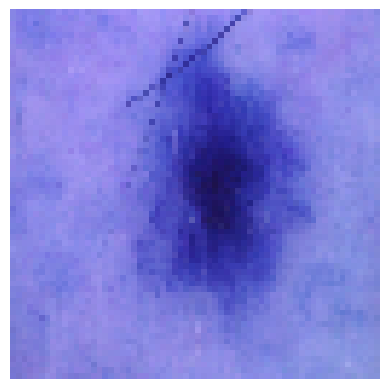

In [198]:
ShowImage(im_orig)

In [199]:
print(type(im_orig))

<class 'numpy.ndarray'>


In [200]:
X_test.shape

(2003, 64, 64, 3)

In [201]:
predictions = model.predict(X_test)

63/63 [==============================] - 3s 47ms/step


In [202]:
print(predictions.shape)

(2003, 7)


In [203]:
prediction_class = np.argmax(predictions[0])

In [204]:
prediction_class

4

In [205]:
im = im_orig.astype(np.float32)

In [206]:
baseline = np.zeros(im.shape)

In [207]:
call_model_args = {class_idx_str: prediction_class}

In [208]:
gradient_saliency = GradientSaliency()

In [209]:
import tensorflow as tf
last_conv_layer = model.get_layer(index=-3)
new_model = tf.keras.models.Model(inputs=model.input, 
                                   outputs=[last_conv_layer.output, model.output])



In [210]:
vanilla_integrated_gradients_mask_3d = gradient_saliency.GetGradientMask(
  im, call_model_function, call_model_args)

In [212]:
def ShowGrayscaleImage(im, title='', ax=None):
  if ax is None:
    P.figure()
  P.axis('off')

  P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
  P.title(title)

In [217]:
def VisualizeImageGrayscale(image_3d, percentile=99):
  r"""Returns a 3D tensor as a grayscale 2D tensor.

  This method sums a 3D tensor across the absolute value of axis=2, and then
  clips values at a given percentile.
  """
  image_2d = np.sum(np.abs(image_3d), axis=2)

  vmax = np.percentile(image_2d, percentile)
  vmin = np.min(image_2d)

  return np.clip((image_2d - vmin) / (vmax - vmin), 0, 1)

In [218]:
vanilla_mask_grayscale = VisualizeImageGrayscale(vanilla_integrated_gradients_mask_3d)

In [220]:
# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

<Figure size 1000x2000 with 0 Axes>

<Figure size 1000x2000 with 0 Axes>

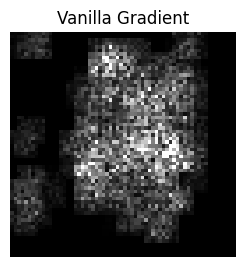

In [221]:
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Gradient', ax=P.subplot(ROWS, COLS, 1))